In [ ]:
# 1. IMPORT LIBRARY
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import (classification_report, 
                           confusion_matrix, 
                           roc_auc_score)
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns


In [13]:
# 2. LOAD & VALIDASI DATA
def load_data(path):
    df = pd.read_csv(path)
    
    # Validasi kolom penting
    required_cols = ['PM2.5', 'NOx', 'VOCs', 'Location_Type', 'Source_Label']
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Kolom yang hilang: {missing_cols}")
    
    # Cek leakage
    for col in ['PM2.5', 'NOx', 'VOCs']:
        if df.groupby('Source_Label')[col].nunique().min() == 1:
            print(f"Peringatan: {col} mungkin mengandung leakage!")
    
    return df

df = load_data("air_quality_dataset.csv")

In [14]:
# 3. PREPROCESSING
# Handle missing values
df.fillna({
    'PM2.5': df['PM2.5'].median(),
    'NOx': df['NOx'].median(),
    'VOCs': df['VOCs'].median(),
    'Location_Type': 'Unknown'
}, inplace=True)

In [15]:
# Encode target
le = LabelEncoder()
y = le.fit_transform(df['Source_Label'])

In [16]:
# 4. FEATURE ENGINEERING
df['Pollution_Index'] = 0.4*df['NOx'] + 0.3*df['VOCs'] + 0.3*df['PM2.5']
df['Is_High_PM'] = (df['PM2.5'] > df['PM2.5'].quantile(0.75)).astype(int)

In [17]:
df

,PM2.5,PM10,NOx,NO2,SO2,VOCs,CO,CO2,CH4,Temperature,Humidity,Wind_Direction,Location_Type,Source_Label,Pollution_Index,Is_High_PM
0,39.967142,57.926035,116.192213,55.230299,4.531693,75.317261,2.789606,427.674347,1.706105,31.085120,45.454749,276,Urban,Vehicular,81.062206,0
1,101.935672,150.774299,76.826826,79.051618,18.744780,145.083987,1.966569,529.739619,2.492663,33.711103,60.798212,134,Industrial,Industrial,104.836628,1
2,70.996192,138.948796,158.731020,60.466604,14.892239,145.147338,2.626446,499.889443,2.431165,33.778698,54.875669,1,Industrial,Industrial,128.335467,0
3,28.464728,63.643900,25.385343,15.333286,7.647429,130.022319,1.779360,388.283712,1.818563,31.565877,67.113319,251,Rural,Biomass Burning,57.700251,0
4,78.265276,113.977926,105.644340,59.202337,17.696806,181.713667,3.240533,464.739197,2.597225,32.229835,37.236519,326,Industrial,Industrial,120.251419,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,51.380025,57.573550,31.124630,19.276010,11.167098,104.071502,1.844483,397.418878,1.923525,34.323410,67.148831,289,Rural,Biomass Burning,59.085310,0
496,46.816837,75.372133,22.174014,18.535162,12.169426,74.802208,1.364096,392.316075,2.157281,26.321361,65.549718,270,Rural,Biomass Burning,45.355319,0
497,33.909351,88.097250,27.630317,15.653370,7.997326,128.105470,2.319453,378.653347,1.809489,28.964494,72.687008,185,Rural,Biomass Burning,59.656573,0
498,43.721651,40.847991,27.253977,19.365916,7.218154,106.053329,1.599748,389.878566,1.858964,29.976442,65.043244,272,Rural,Biomass Burning,55.834085,0


In [18]:
# 5. PEMISAHAN FITUR-TARGET
features = ['PM2.5', 'NOx', 'VOCs', 'Pollution_Index', 'Is_High_PM', 'Location_Type']
X = df[features]
y = le.transform(df['Source_Label'])

In [21]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder


# 6. PIPELINE MODEL
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), ['PM2.5', 'NOx', 'VOCs', 'Pollution_Index']),
    ('cat', OneHotEncoder(), ['Location_Type'])
])

dt_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('model', DecisionTreeClassifier(random_state=42))
])

In [22]:
# 7. OPTIMASI HYPERPARAMETER
param_grid = {
    'model__max_depth': [3, 5, 7, None],
    'model__min_samples_split': [2, 5, 10],
    'model__criterion': ['gini', 'entropy'],
    'model__class_weight': [None, 'balanced']
}

grid_search = GridSearchCV(dt_pipeline, param_grid, 
                         cv=5, 
                         scoring='f1_weighted',
                         n_jobs=-1)
grid_search.fit(X, y)

best_model = grid_search.best_estimator_
print(f"Best Params: {grid_search.best_params_}")

Best Params: {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 3, 'model__min_samples_split': 2}


In [23]:
# 8. EVALUASI MODEL
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [24]:
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)

In [25]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))


Classification Report:
                 precision    recall  f1-score   support

Biomass Burning       1.00      1.00      1.00        34
     Industrial       1.00      1.00      1.00        36
      Vehicular       1.00      1.00      1.00        30

       accuracy                           1.00       100
      macro avg       1.00      1.00      1.00       100
   weighted avg       1.00      1.00      1.00       100



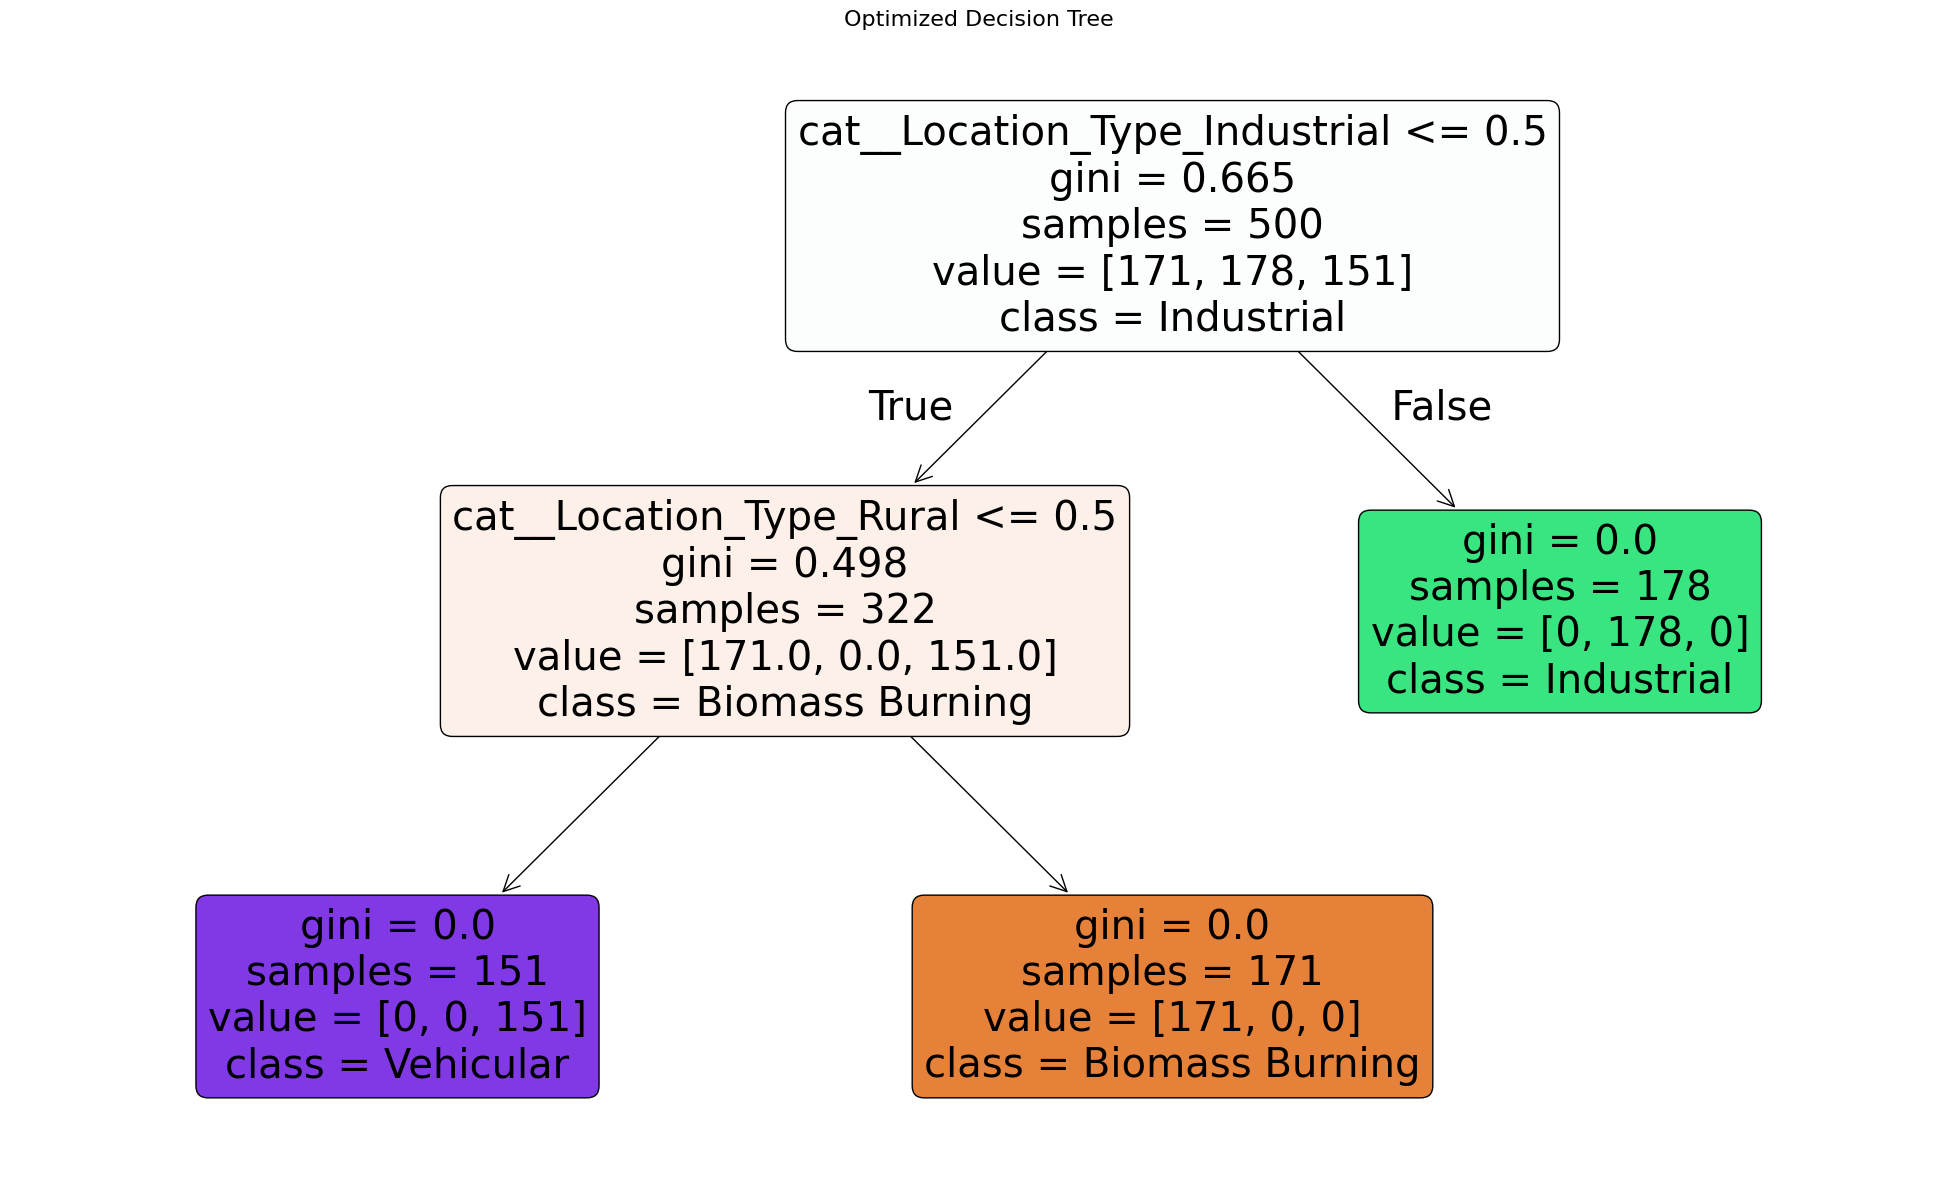

In [26]:
# 9. VISUALISASI
plt.figure(figsize=(25,15))
plot_tree(best_model.named_steps['model'], 
          feature_names=best_model[:-1].get_feature_names_out(),
          class_names=le.classes_, 
          filled=True, 
          rounded=True,
          max_depth=2)  # Batasi kedalaman untuk readability
plt.title("Optimized Decision Tree", fontsize=16)
plt.show()

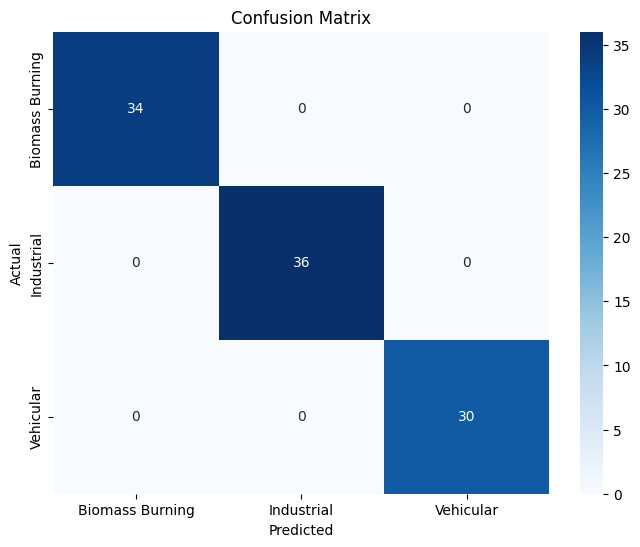

In [29]:
# 12. CONFUSION MATRIX
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', 
            xticklabels=le.classes_, 
            yticklabels=le.classes_,
            cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()